<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans cet exemple, nous allons entrainer un auto encodeur sur les données Fashion Minist, lesquels contiennent plusieurs images de vêtements (pantalons, chandails, souliers).

Vous pouvez consulter le lien suivant pour tous les détails sur ce jeu de données:
https://www.tensorflow.org/datasets/catalog/fashion_mnist

1. Importation des packages utiles

In [44]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers, models, datasets, callbacks, metrics
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

2. Importer les données

In [45]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

3. Visualiser quelques images

NOTE: 0: t-shirt, 1: pantalons, 2: pull, 3: robe, 4: manteau, 5: sandale, 6: chemise, 7: soulier, 8: sac, 9: botte

Images: 


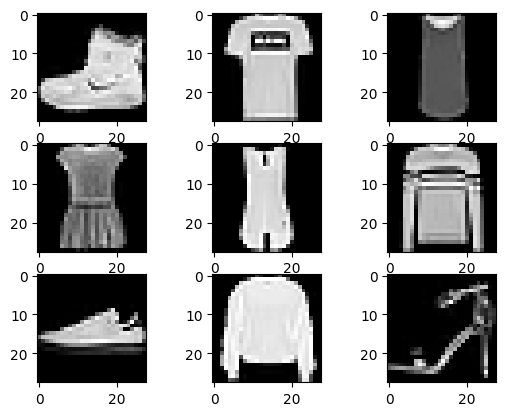

Labels:  [9 0 0 3 0 2 7 2 5]


In [46]:
print("Images: ")

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Labels: ", y_train[0:9])

4. Pré-processing des images (normalisation et reshape des images)

In [47]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

X_train = preprocess(X_train)
X_test = preprocess(X_test)

print(X_train.shape, X_test.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1)


5. On déclare quelques constantes utiles

In [48]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2        #Ce paramètre dicte la dimension du vecteur de "code" qui encodera les image - ici, on va tenter d'encoder chaqye image avec 2 valeurs seulement, wow !
EPOCHS = 3

6. On bâtit l'encodeur à l'aide de l'API Functionnal de Keras

In [49]:
### ENCODER INPUT
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # nécessaire pour le décodeur plus tard

x = layers.Flatten()(x)

### ENCODER OUTPUT
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (3

7. On bâtit le décodeur à l'aide de l'API Functionnal de Keras

In [50]:
### DECODER INPUT
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

### DECODER OUTPUT
decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

#### DECODER
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_15 (Dense)            (None, 2048)              6144      
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        184

######

AUTO-ENCODER

####

8. On bâtit l'auto-encodeur en combinant l'encodeur et le décodeur

In [51]:
### AUTOENCODER: encoder_[input, output]
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_13 (Functional)       (None, 32, 32, 1)         246

9. Compiler le modèle

In [52]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

10. Entrainer le modèle

In [53]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

#### Attention: X_train, X_train (and not y_train) : because you´re trying to forecast X_train
autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_test, X_test), callbacks=[model_checkpoint_callback, tensorboard_callback],)

Epoch 1/3
600/600 [==============================] - 11s 13ms/step - loss: 0.2991 - val_loss: 0.2618
Epoch 2/3
600/600 [==============================] - 7s 12ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 3/3
600/600 [==============================] - 8s 13ms/step - loss: 0.2532 - val_loss: 0.2533


11. Enregistrer le modèle

In [54]:
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

12. Reconstruction des images avec l'autoencodeur

157/157 [==============================] - 1s 3ms/step
Images initiales: 


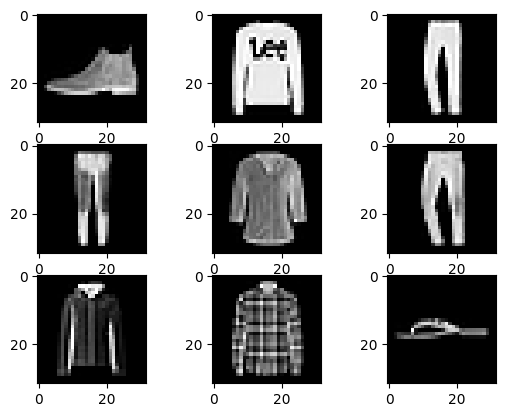

Reconstructions: 


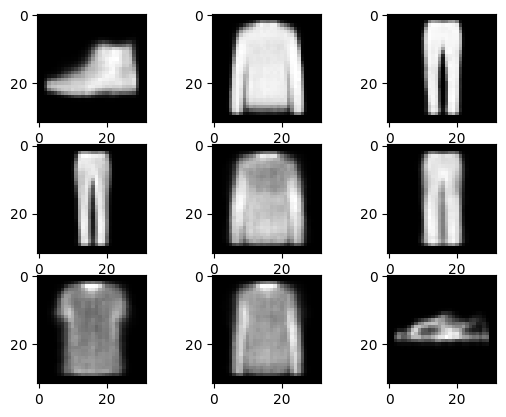

In [55]:
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

print("Images initiales: ")

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_test[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Reconstructions: ")

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(predictions[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

13. Utilisation de l'encodeur (première partie du modèle) pour encoder (=to embed) un image

In [56]:
embeddings = encoder.predict(example_images)
print(embeddings[:10])

157/157 [==============================] - 0s 2ms/step
[[-2.038116   -1.3637494 ]
 [ 4.160991    0.8173514 ]
 [ 3.3796074  -9.652566  ]
 [ 1.3533705  -7.690179  ]
 [ 1.7606558   0.08889581]
 [ 2.8654523  -5.7050247 ]
 [ 1.4947004  -1.7183045 ]
 [ 1.8516392  -0.43498904]
 [-4.905142   -3.2994318 ]
 [-4.5003347  -1.5250841 ]]


14. Représentation des images encodés dans un graphique (en 2D)

NOTE: 0: t-shirt, 1: pantalons, 2: pull, 3: robe, 4: manteau, 5: sandale, 6: chemise, 7: soulier, 8: sac, 9: botte

NOTE 2: constatez à quel point les vêtements similaires se retrouvent "proche" les uns des autres dans la vectorisation 2D (une fois encodé), par exemple les sendales (5: vert pale) sont très près des souliers (7: orange pale), lesquels sont très près des bottes (9: rouge foncé)

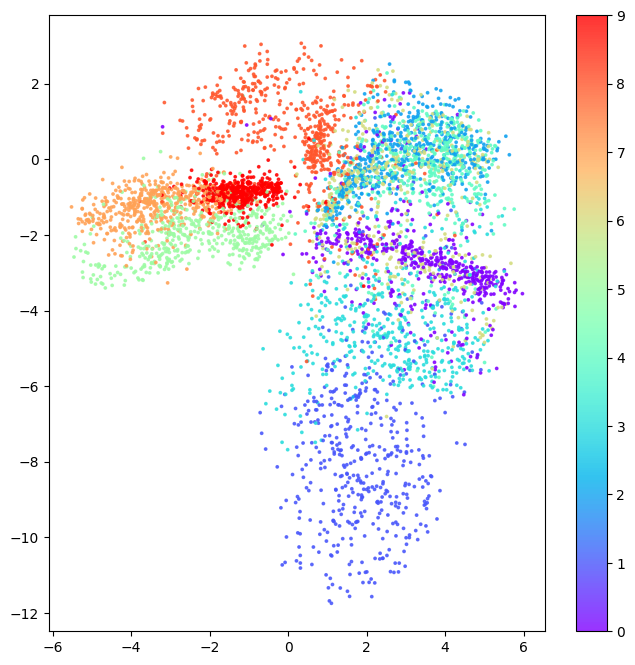

In [57]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

15. Utilisation du décodeur (deuxième partie du modèle) pour générer de nouvelles images de vêtements

NOTE: l'idée est de simuler un vecteur 2D dans le range des valeurs possibles générés par l'encodeur, puis de passer ce vecteur au décodeur pour obtenir de nouvelles images

In [58]:
#Obtenir le range des valeurs possibles
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
print(mins, max)

#Simuler un vecteur d'encoding (18 fois = 6 x 3) dans l'espace latent de l'encodeur
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM))
print(sample)

#Décoder les vecteurs 2D en image à l'aide du décodeur (ce qui transformera les vecteurs 2D simulés en images)
reconstructions = decoder.predict(sample)

[ -5.5163226 -11.743455 ] <built-in function max>
[[ -3.98455889  -2.46693507]
 [ -3.67384328  -3.7130693 ]
 [ -3.16273533  -1.17508314]
 [  5.35201633  -5.21229022]
 [  4.24878661  -1.02235698]
 [ -3.79710642   0.17954119]
 [ -4.4875139    1.23355569]
 [  4.6137748    0.33970301]
 [ -0.27612431  -9.46858894]
 [  0.65626147  -3.20904483]
 [  2.06064971   0.55636759]
 [ -1.7469932   -4.46215403]
 [ -4.24899966  -5.31103771]
 [  2.91959954   0.82544486]
 [ -4.4775091   -3.72589119]
 [  0.4886108   -1.10737637]
 [ -1.04987772  -2.08245197]
 [ -3.34978752 -10.98639298]]
1/1 [==============================] - 0s 105ms/step


16. Représentation graphique des images générés

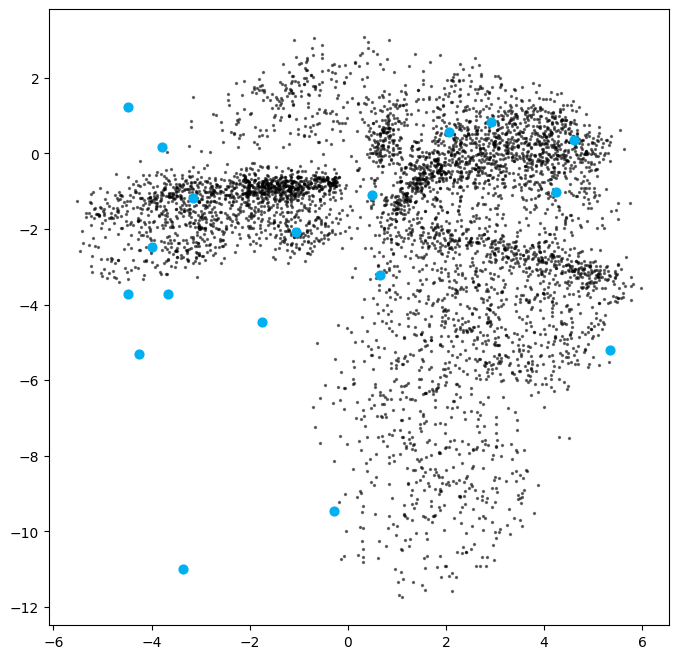

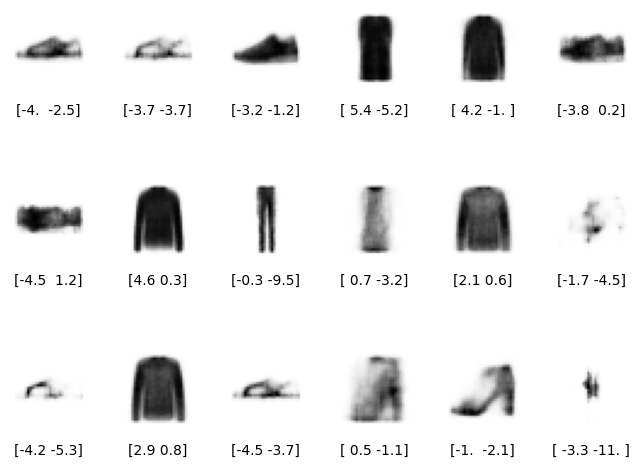

In [59]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

#Embeddings originaux (en noir sur le 1er graphique)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

#Nouveaux points générés (gros points bleu sur le 1er graphique)
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

#Images décodées (2e graphique)
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")



17. Résonnement génératif: essayons de faire un peu d'arithmtique dans l'espace latent en transformant un soulier (-4, -5) en botte (-4, 0)

NOTE: les valeurs des encodings changent selon l'entrainement, il faut donc ajuster les valeurs de z_A et de z_B plus bas en trouvant les coordonnées des objets, par exemple dans le graphique en couleur plus haut

In [60]:
#Définir les vecteurs encodés de l'image de départ (z_A) et de l'image d'arrivée (z_B)
z_A = np.array([-4 , -5])
Z_B = np.array([-4 , 0])
z=[]

#Générer des points intermédiaires entre z_A et z_B (ici, linéairement), puis afficher les vecteurs résultants
for i in range(18):
  z.append(z_A*(1-i/17) + Z_B * (i/17))

#Valider que les points ont un bon format
z=np.array(z)
print(z)

#Décoder les vecteurs 2D en image à l'aide du décodeur (ce qui transformera les vecteurs 2D simulés en images)
reconstructions = decoder.predict(z)


[[-4.         -5.        ]
 [-4.         -4.70588235]
 [-4.         -4.41176471]
 [-4.         -4.11764706]
 [-4.         -3.82352941]
 [-4.         -3.52941176]
 [-4.         -3.23529412]
 [-4.         -2.94117647]
 [-4.         -2.64705882]
 [-4.         -2.35294118]
 [-4.         -2.05882353]
 [-4.         -1.76470588]
 [-4.         -1.47058824]
 [-4.         -1.17647059]
 [-4.         -0.88235294]
 [-4.         -0.58823529]
 [-4.         -0.29411765]
 [-4.          0.        ]]
1/1 [==============================] - 0s 17ms/step


18. Visialisations des images décodées

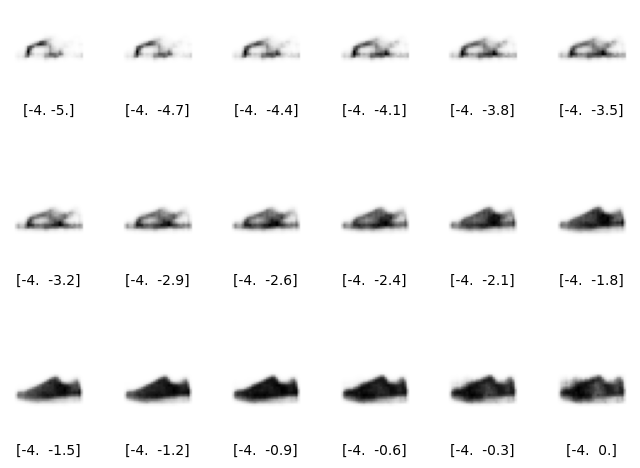

In [70]:
fig = plt.figure(figsize=(figsize, grid_height * 2))

## change these params to see the images morphing
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Approfondissement avec le Variational auto-encodeur (VAE), lequel tente d'avoir chaque vecteur d'encoding (1) le plus prè possible de 0 et (2) distribué le plus possible selon une loi normale (en ajoutant la divergence KL à la fonction de perte)

19. Fonctions pour générer du noise selon une loi normale

In [71]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

20. Définition du VAE

In [72]:
codings_size = 10

inputs = layers.Input(shape=[32, 32,1])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation="selu")(z)
z = layers.Dense(100, activation="selu")(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation="selu")(decoder_inputs)
x = layers.Dense(150, activation="selu")(x)
x = layers.Dense(32 * 32, activation="sigmoid")(x)
outputs = layers.Reshape([32, 32, 1])(x)
variational_decoder = models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1) #Calcul de la divergence KL
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,validation_data=(X_test, X_test))

Epoch 1/25
469/469 [==============================] - 5s 6ms/step - loss: 0.3339 - accuracy: 0.6070 - val_loss: 0.2933 - val_accuracy: 0.6183
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2795 - accuracy: 0.6177 - val_loss: 0.2727 - val_accuracy: 0.6174
Epoch 3/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2708 - accuracy: 0.6184 - val_loss: 0.2719 - val_accuracy: 0.6155
Epoch 4/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2651 - accuracy: 0.6191 - val_loss: 0.2632 - val_accuracy: 0.6172
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2609 - accuracy: 0.6197 - val_loss: 0.2608 - val_accuracy: 0.6191
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.2582 - accuracy: 0.6200 - val_loss: 0.2567 - val_accuracy: 0.6186
Epoch 7/25
469/469 [==============================] - 3s 5ms/step - loss: 0.2562 - accuracy: 0.6202 - val_loss: 0.2561 - val_accuracy: 0.6193
Epoch 

21. Visualisation de quelques images reconstruites

157/157 [==============================] - 1s 3ms/step
Images initiales: 


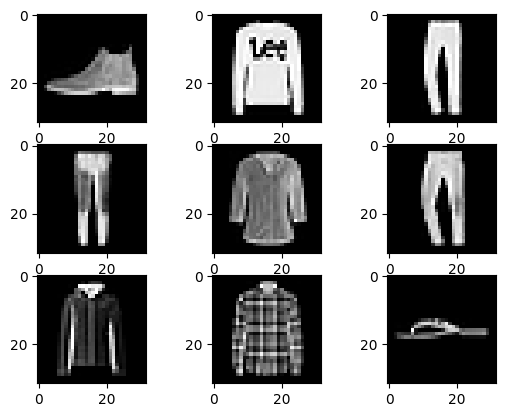

Reconstructions: 


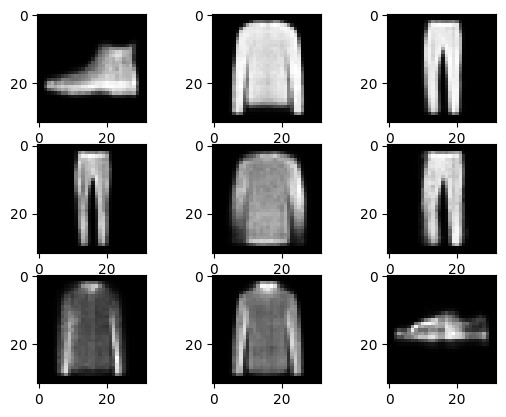

In [40]:
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = variational_ae.predict(example_images)

print("Images initiales: ")

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(X_test[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Reconstructions: ")

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(predictions[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

22. Utilisation du décodeur pour générer des images

In [23]:
codings = tf.random.normal(shape=[18, codings_size])
images = variational_decoder(codings).numpy()
print(codings[:3])

tf.Tensor(
[[ 2.8447378   0.01734671 -0.51881814  0.11504476  1.426747    0.01608387
  -0.9133447   1.2824385   0.06537963 -0.09561815]
 [ 0.7314881  -0.950881    1.4842846  -0.22634281 -0.7188931  -0.04022122
  -0.13994645  1.731516   -0.24620017 -0.28833345]
 [-0.14284666  1.945603    0.5985604  -0.9974599   0.54610616  1.527581
   1.151706   -1.2500141  -0.4982542   0.9719069 ]], shape=(3, 10), dtype=float32)


23. Tracer les images générées

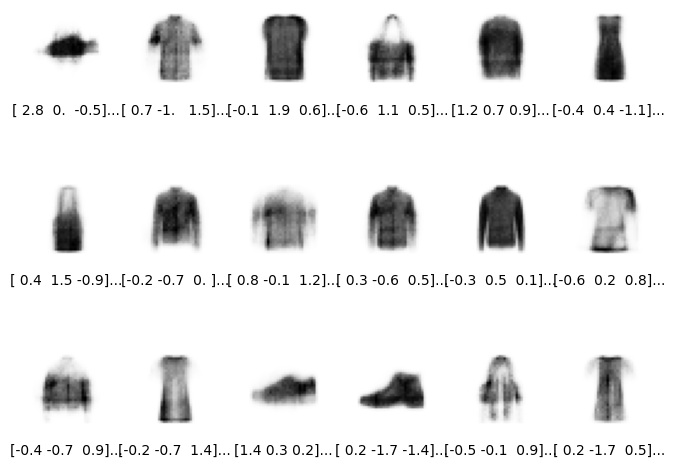

In [24]:
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(codings[i, :3], 1) ) + "...",
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(images[i, :, :], cmap="Greys")